This notebook, is a built up from our previous notebook. It uses transfer learning and finetuning from the imagenet dataset.

In [1]:
import pandas as pd
import os
from PIL import Image
import io
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np

/Users/leemabhena/Documents/williams-cs/python-practice/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


The dataset contains 40 labels and over 200,000 images. The initial stage involves combining the dataset into tfrecords. *Why use tfrecords?*

TFRecords: TFRecords is a binary file format for storing data. Using TFRecords has several advantages, especially when working with large datasets like ours:

1. **Efficiency:** TFRecords store data in a sequence of binary strings, which takes less space on disk and can be read more efficiently from disk, especially useful for large datasets.

2. **Performance:** Data in a TFRecord format can be read quickly, which is crucial for training deep learning models efficiently. TensorFlow is optimized to read from TFRecords, enabling faster input pipelines compared to reading data from other file formats.

3. **Scalability:** TFRecords support a large amount of data in a single file, which is beneficial for processing and managing large datasets. It also supports distributed training by splitting data easily across multiple machines.

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [3]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [4]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [5]:
def serialize_example(image, features):
    feature = {
        'image': _bytes_feature(image),
        'features': tf.train.Feature(float_list=tf.train.FloatList(value=features))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [6]:
# Create a tf records and save it to a file
def create_tfrecord(csv_path, images_folder, output_path):
    df = pd.read_csv(csv_path)
    df.replace(-1, 0, inplace=True)
    feature_columns = df.columns.tolist()
    feature_columns.remove('image_id')  # Remove the image_id from features

    with tf.io.TFRecordWriter(output_path) as writer:
        for _, row in df.iterrows():
            image_path = os.path.join(images_folder, f"{row['image_id']}")
            if not os.path.exists(image_path):
                continue
            image = Image.open(image_path)
            image_bytes = io.BytesIO()
            image.save(image_bytes, format='JPEG')
            image_bytes = image_bytes.getvalue()

            features = row[feature_columns].values.astype(float)
            example = serialize_example(image_bytes, features)
            writer.write(example)

In [7]:
# Read in the facial attributes dataset
df_path = "./list_attr_celeba.csv"
# Define paths
image_folder = '/Users/leemabhena/Downloads/deep_learning_project/img_align_celeba/img_align_celeba'

In [8]:
# Create tfrecord named output
create_tfrecord(df_path, image_folder, 'output.tfrecords')

Code to read and parse tf records.

In [8]:
# Start building the model
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'features': tf.io.FixedLenFeature([40], tf.float32)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def decode_image_and_resize(features):
    image = tf.image.decode_jpeg(features['image'], channels=3)
    image = tf.image.resize(image, [150, 150])  # (178, 218) Resize to the input size required by the model
    return image, features['features']

def load_dataset(tfrecord_file, start_index, end_index):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.enumerate().filter(lambda idx, _: idx >= start_index and idx < end_index)
    dataset = dataset.map(lambda idx, data: parse_tfrecord(data))
    dataset = dataset.map(decode_image_and_resize)
    return dataset

In [9]:
def load_dataset(tfrecord_file, start_index, end_index):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.enumerate().filter(lambda idx, _: idx >= start_index and idx < end_index)
    dataset = dataset.map(lambda idx, data: parse_tfrecord(data))
    dataset = dataset.map(decode_image_and_resize)
    return dataset

def get_dataset_size(file_paths):
    count = 0
    corrupted = 0
    dataset = tf.data.TFRecordDataset(file_paths)
    for record in dataset:
        try:
            # Attempt to parse the record
            parsed_record = tf.io.parse_single_example(record, {
                'image': tf.io.FixedLenFeature([], tf.string),
                'features': tf.io.FixedLenFeature([40], tf.float32)
            })
            count += 1
        except tf.errors.DataLossError:
            corrupted +=1
    print(corrupted)
    return count

Check the integrity of the tfrecord, whether all the images and labels were written successfully and print a single image just for verification.

In [14]:
print(get_dataset_size('output.tfrecords'))

0
202599


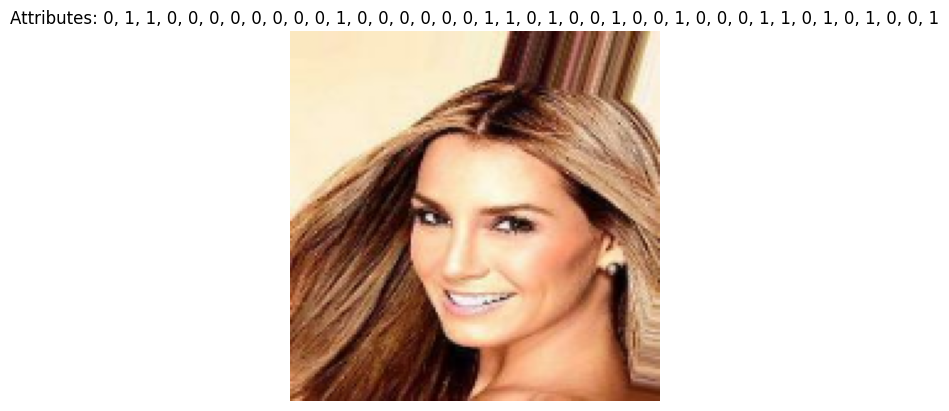

In [10]:
# Load a single entry from the dataset
def load_single_example(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(decode_image_and_resize)
    for image, features in dataset.take(1):  # Take one example
        return image.numpy(), features.numpy()  # Convert tensors to numpy arrays for display

# Display the image and labels
def display_image_and_labels(image, labels):
    plt.imshow(image / 255.0)  # Normalize and display the image
    plt.title("Attributes: " + ", ".join([str(int(label)) for label in labels]))
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage
image, labels = load_single_example('output.tfrecords')
display_image_and_labels(image, labels)

Load the dataset and check for any class imbalances. We could not use all of the dataset as it is extremely slow to train the model, using just 20000 training samples took way over 8 hours for just 10 epochs. In the dataset it was recommended to use the range 0 - 162770 for training, 162771, 182637 for validation and remaining for testing. We just used a subset from each of those ranges.

In [79]:
train_dataset = load_dataset('output.tfrecords', 0, 20000) # 0 - 162770
validation_dataset = load_dataset('output.tfrecords', 162771, 167771) # 162771, 182637
test_dataset = load_dataset('output.tfrecords', 182638, 187638) # 182638, 202599

2024-05-12 18:15:04.217074: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-05-12 18:15:04.323098: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-05-12 18:15:04.346797: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [56]:
def calculate_label_distribution(dataset):
    label_sums = np.zeros(40)

    # Iterate over each batch in the dataset
    for _, labels in dataset:
        # Sum up the labels in the batch
        label_sums += np.array(labels)

    return label_sums

In [57]:
train_label_distribution = calculate_label_distribution(train_dataset)
validation_label_distribution = calculate_label_distribution(validation_dataset)
test_label_distribution = calculate_label_distribution(test_dataset)

In [59]:
def calculate_percentages(label_counts, total_samples):
    # Calculate the percentage of positive labels for each label
    percentages = (label_counts / total_samples) * 100
    return percentages

# Calculate total number of samples in each dataset slice
total_train_samples = 20000
total_validation_samples = 167771 - 162771
total_test_samples = 187638 - 182638

train_percentages = calculate_percentages(train_label_distribution, total_train_samples)
validation_percentages = calculate_percentages(validation_label_distribution, total_validation_samples)
test_percentages = calculate_percentages(test_label_distribution, total_test_samples)


In [62]:
df = pd.read_csv(df_path)
feature_columns = df.columns.tolist()
feature_columns.remove('image_id')

In [75]:
def plot_label_distribution(data_percentages, feature_columns):
    fig, axes = plt.subplots(8, 5, figsize=(20, 32))  

    for i, percentage in enumerate(data_percentages):
        # Locate the position in the grid
        row = i // 5
        col = i % 5
        ax = axes[row, col]  # Access the subplot position
        
        # Plotting only on the ax specified
        ax.bar(['Negative', 'Positive'], [100 - percentage, percentage], color=['red', 'green'])
        ax.set_ylim(0, 100)  
        ax.set_title(feature_columns[i])
        ax.set_ylabel('% of Samples')
        ax.set_xticks(['Negative', 'Positive'])  

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Class distribution in train dataset


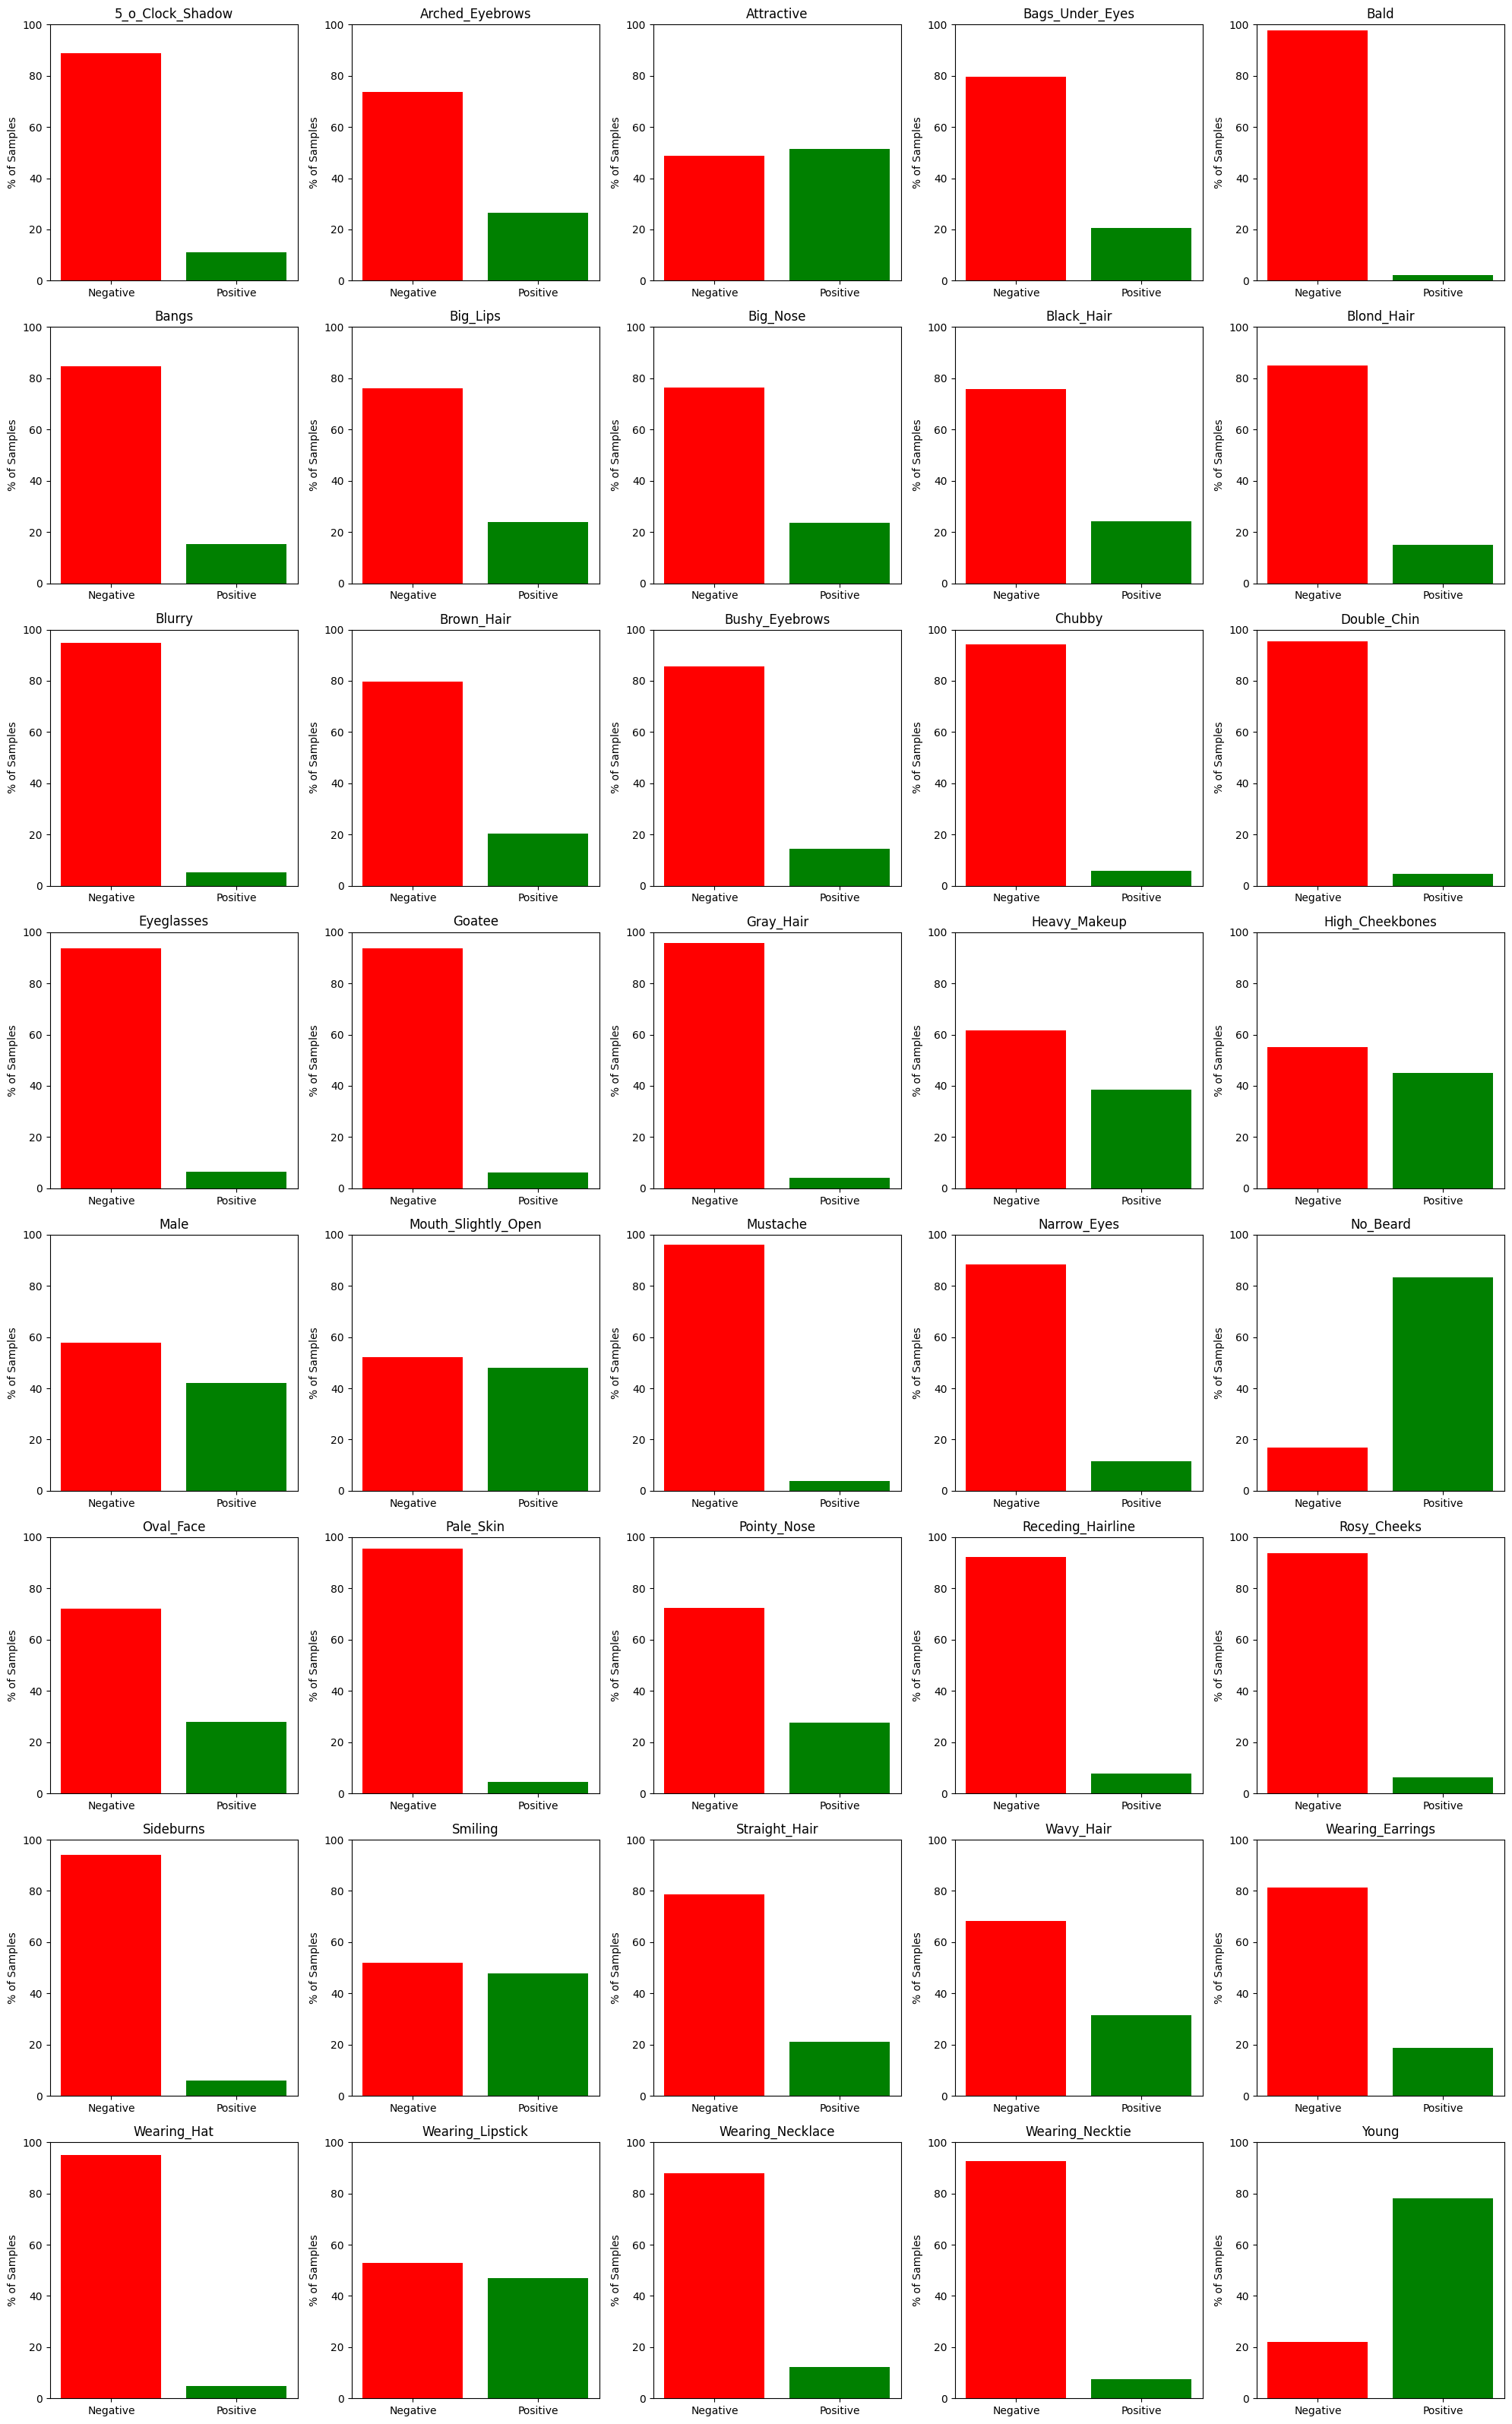

Class distribution in validation dataset


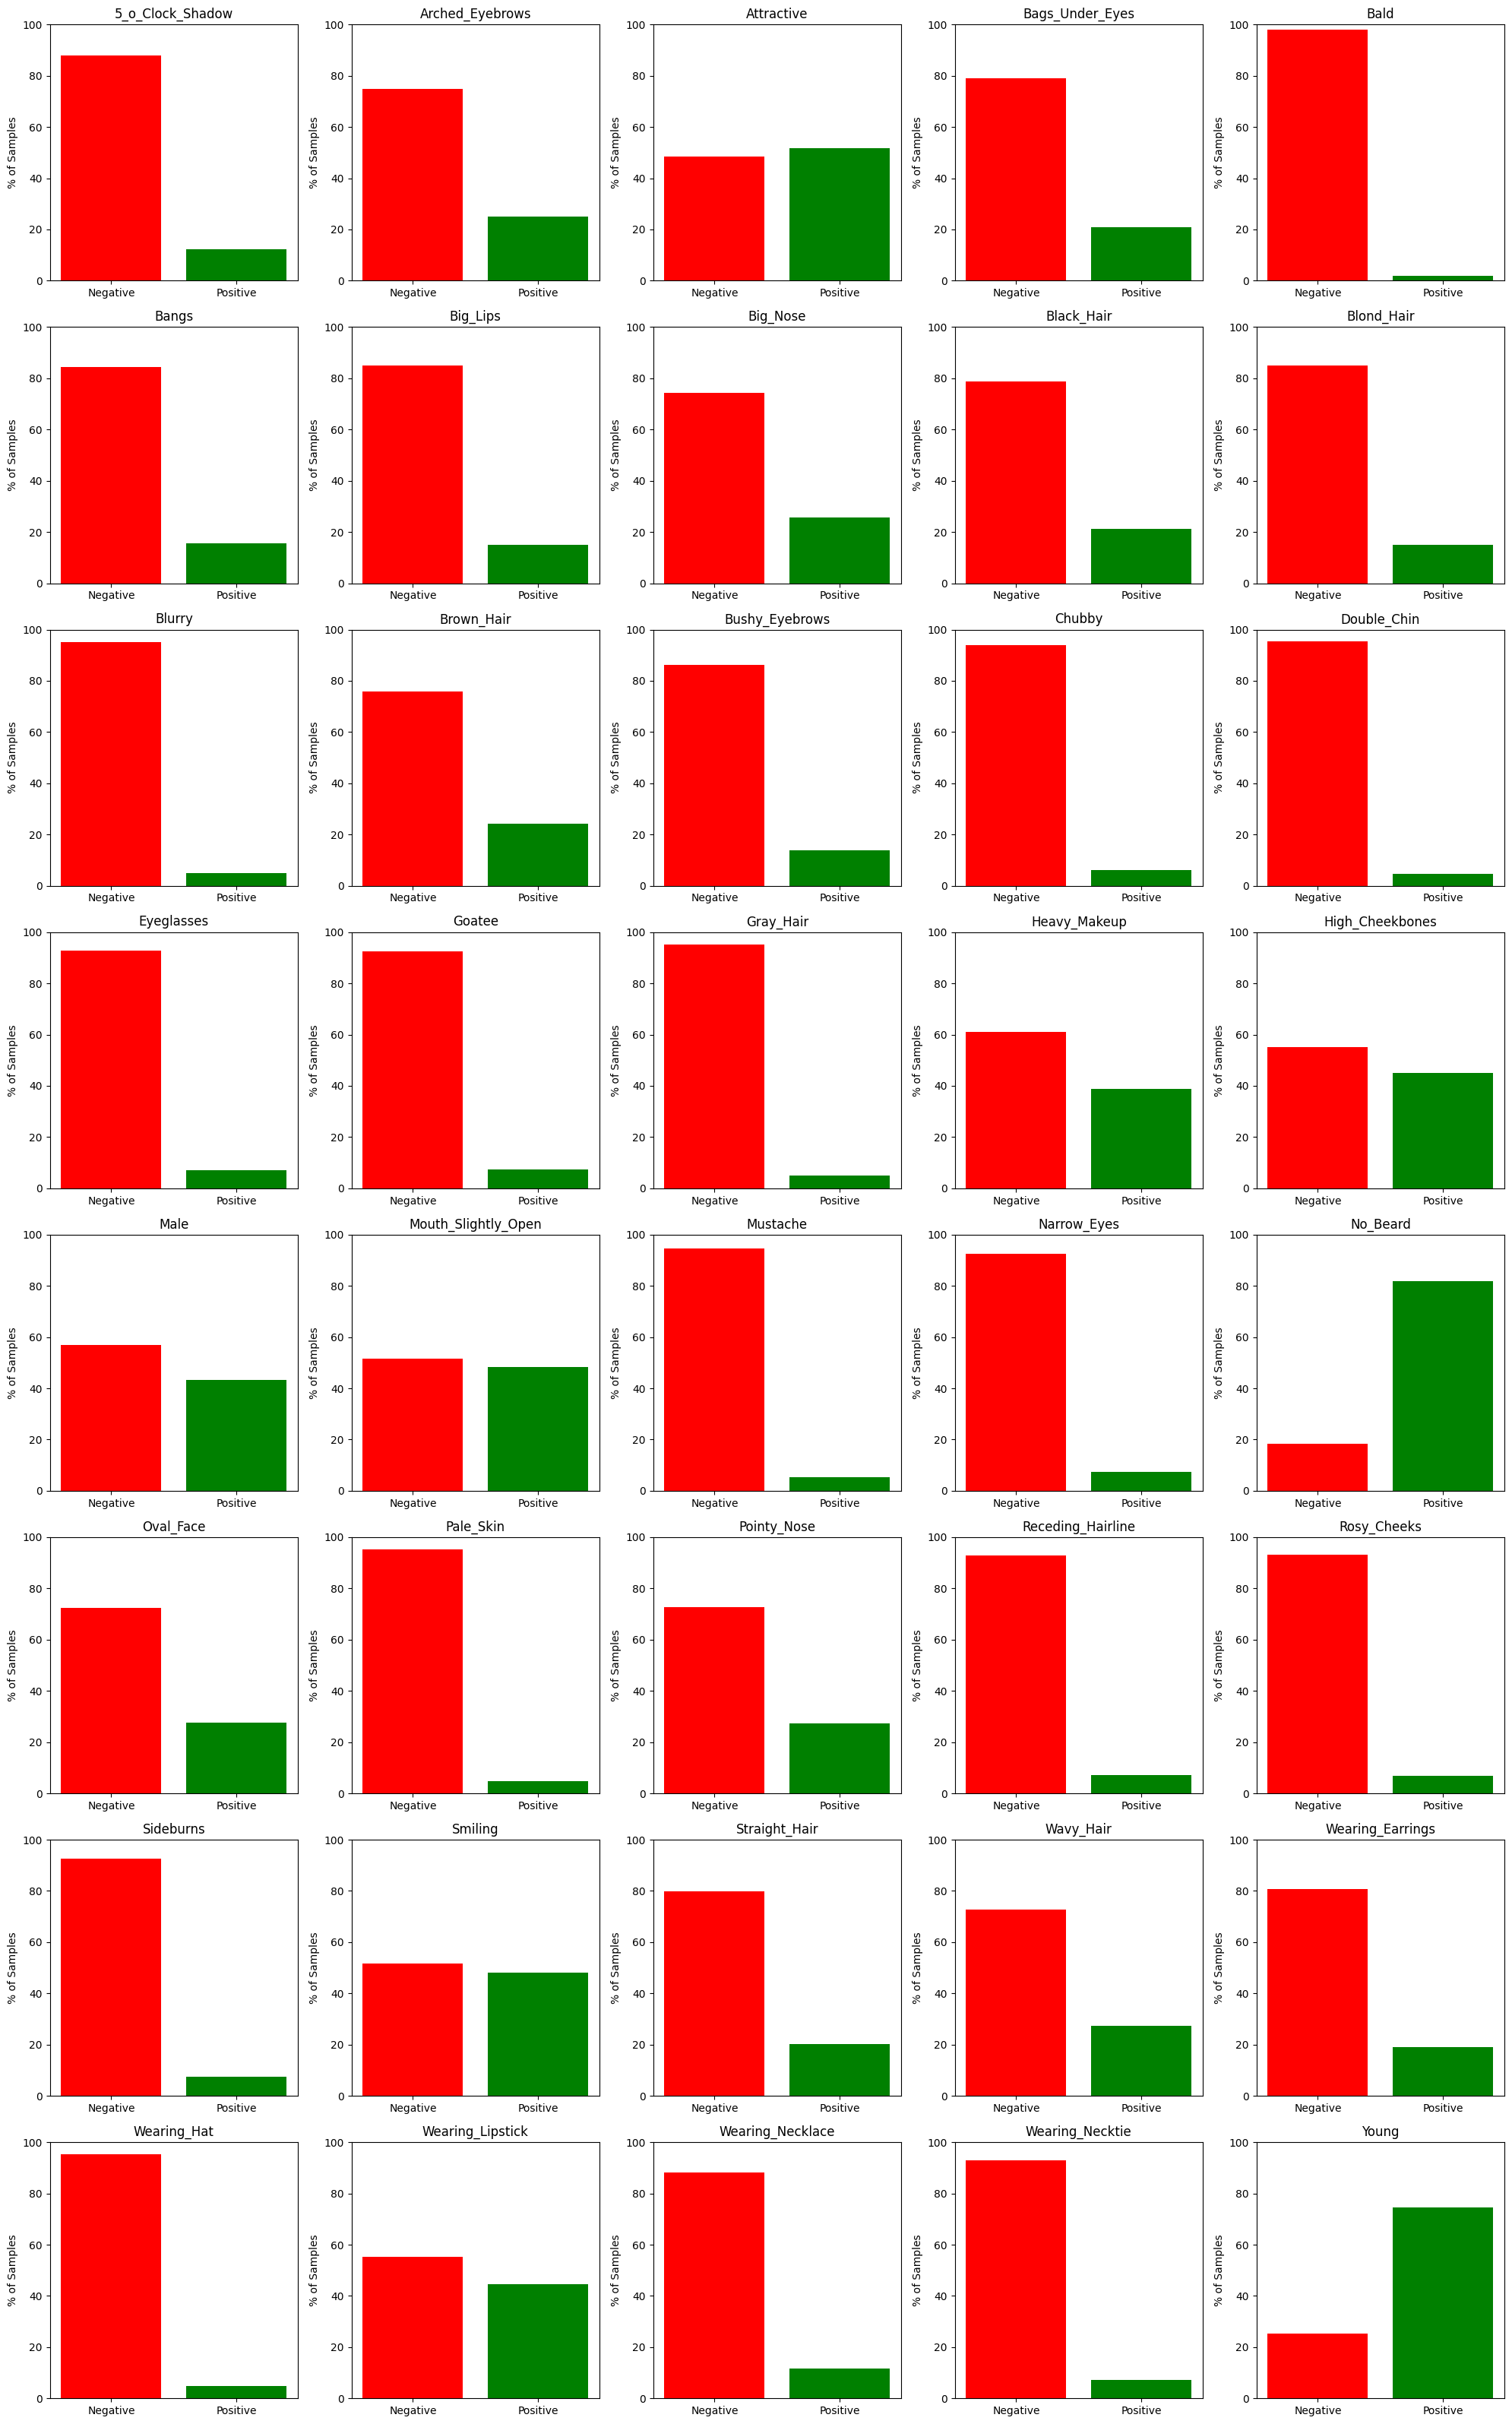

Class distribution in test dataset


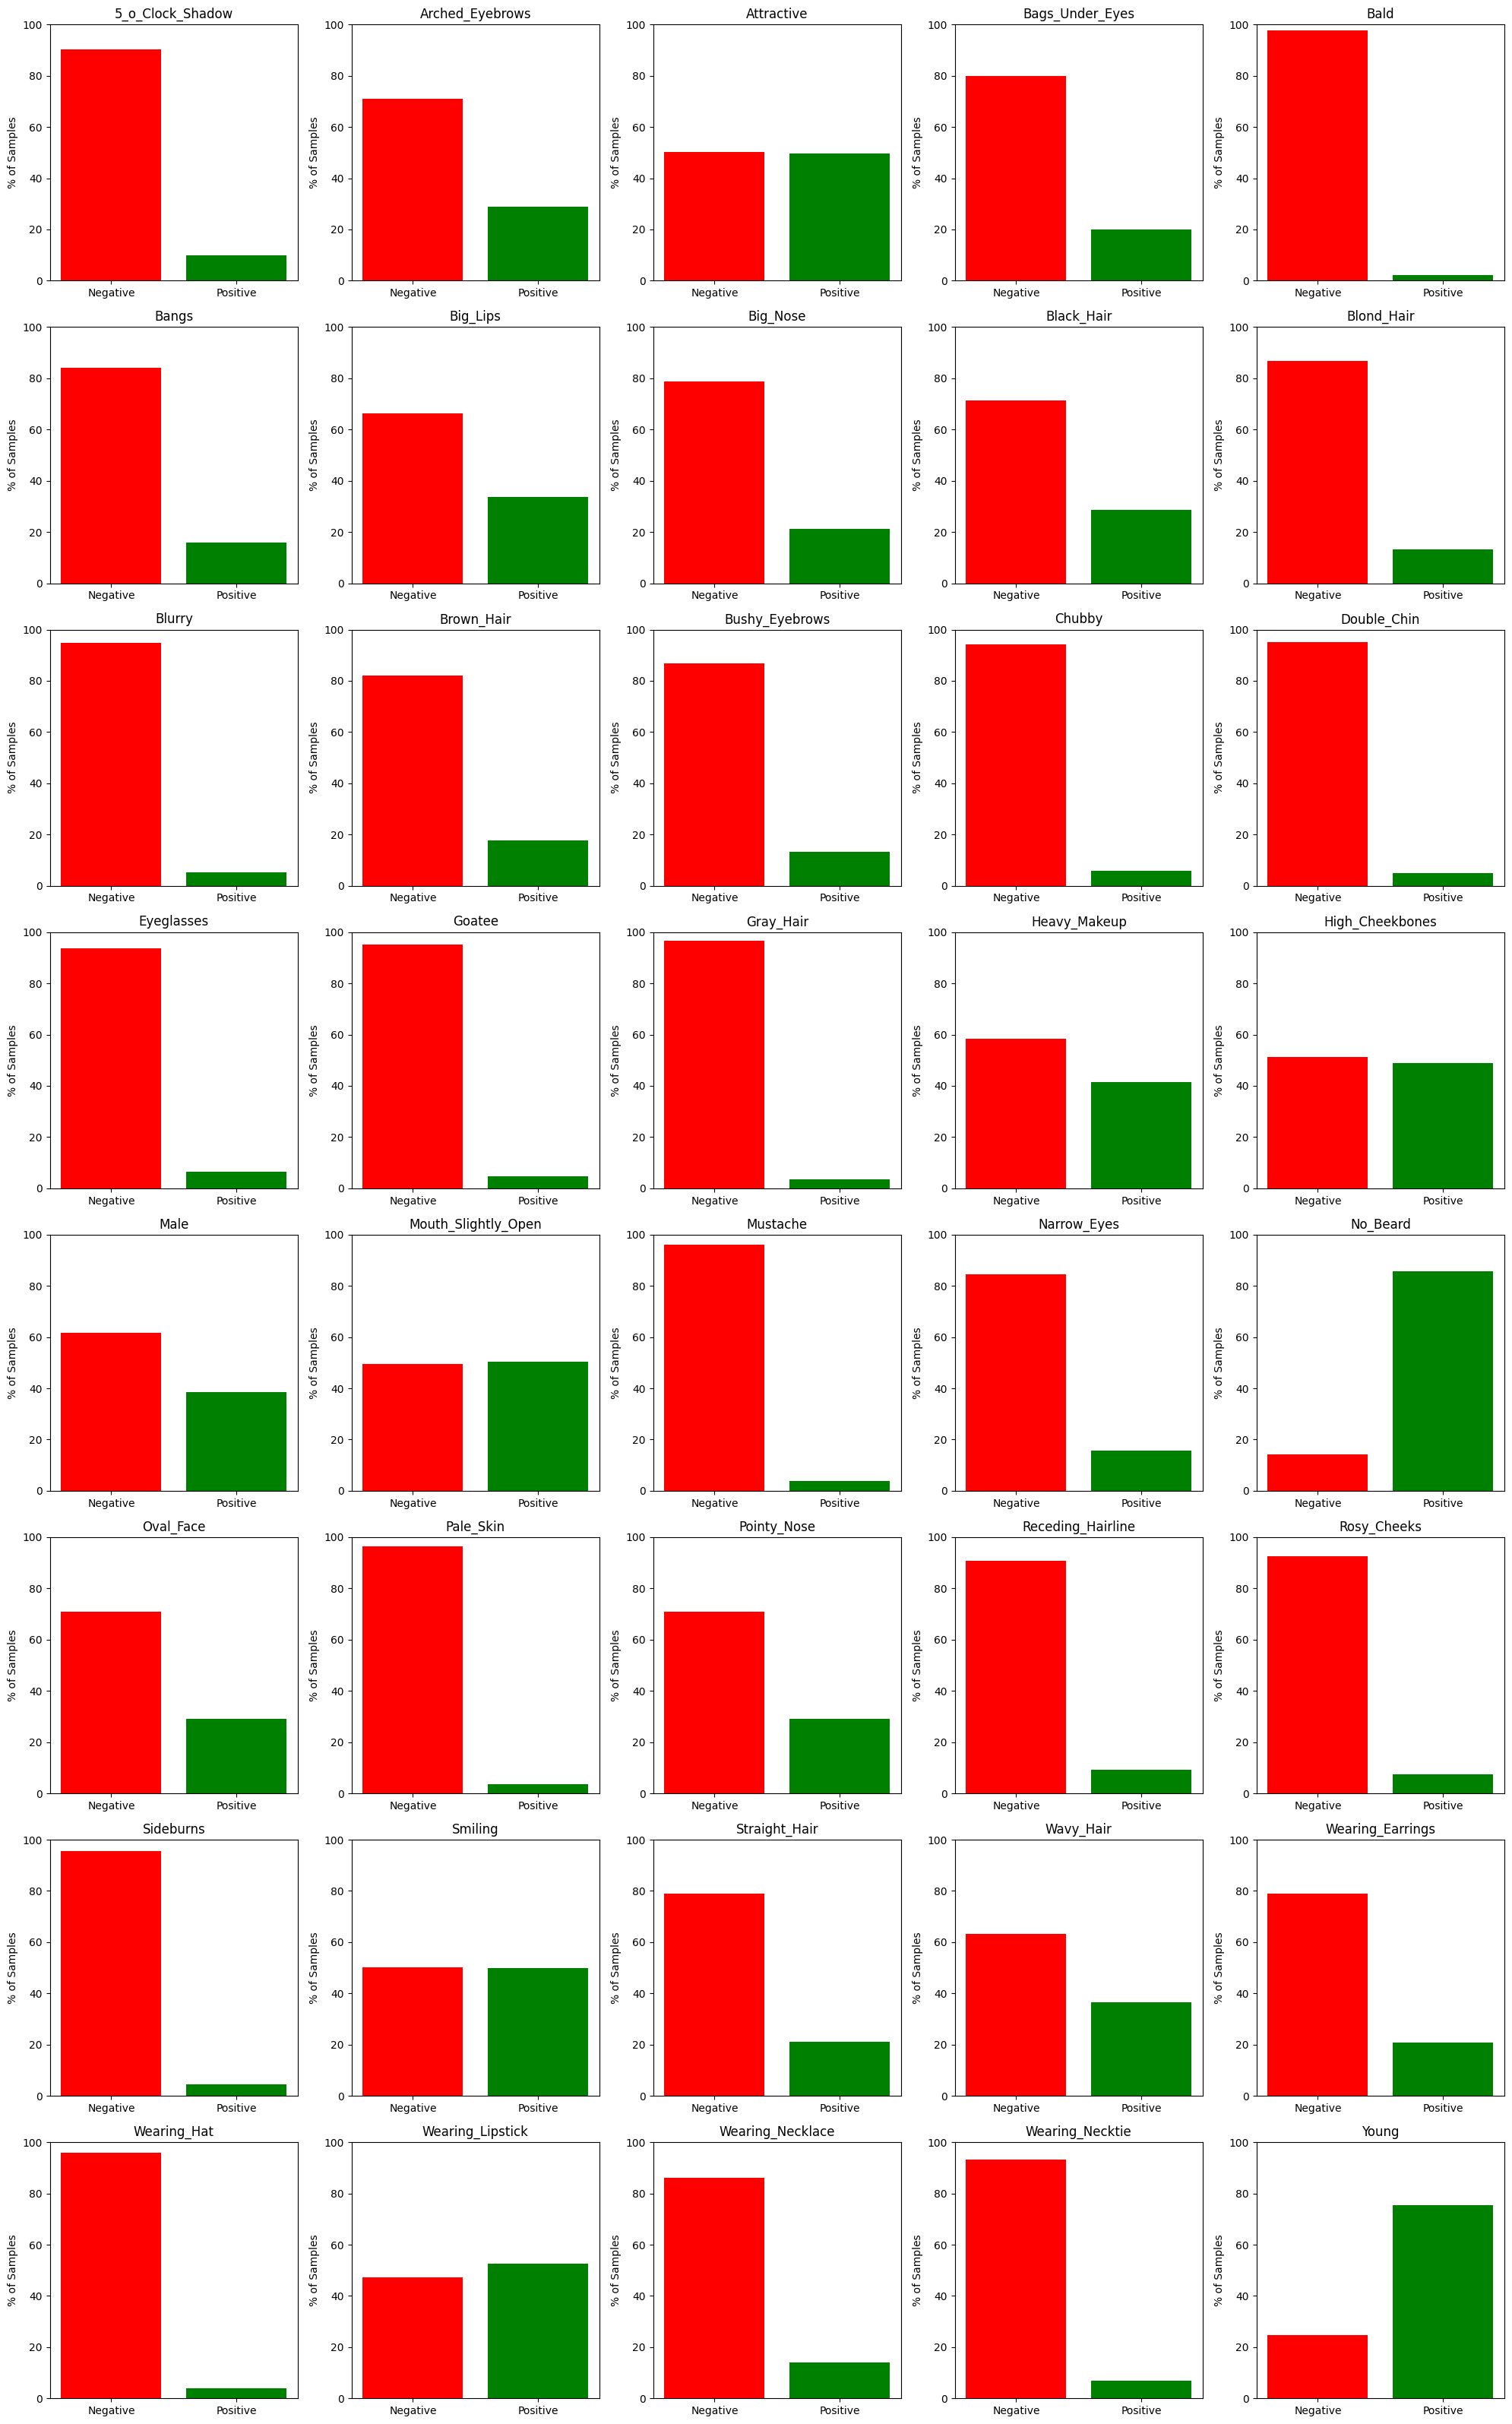

In [77]:
print("Class distribution in train dataset")
plot_label_distribution(train_percentages, feature_columns)
print("Class distribution in validation dataset")
plot_label_distribution(validation_percentages, feature_columns)
print("Class distribution in test dataset")
plot_label_distribution(test_percentages, feature_columns)

The dataset is highly imbalanced with more values for the 0th class, meaning which should be more careful in choosing the threshold of the classification.

In [80]:
# Batch and prefetch
train_dataset = train_dataset.batch(256).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(256).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(256).prefetch(tf.data.experimental.AUTOTUNE)

Build the model, using transfer learning from the image net dataset. The model uses -1 for negative values and 1 for positive values thus the need to rescale our dataset from the current 0, 1 labels we have.

In [15]:
# Transfer learning
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)

In [16]:
# Freeze the model
base_model.trainable = False

In [17]:
# Create a new model top
inputs = keras.Input(shape=(150, 150, 3))

# Rescale the inputs to be between -1 and 1 for use with image net
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# Add the base model in inference mode, for use with Batch Normalization
x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout layer
x = keras.layers.Dropout(0.2)(x)

# A Dense classifier with a 40 outputs
outputs = keras.layers.Dense(40, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [18]:
# Custom callbacks to view how the model is doing at each stage
class PredictionCallback(keras.callbacks.Callback):
    
    def __init__(self, sample_image, true_labels):
        super(PredictionCallback, self).__init__()
        self.sample_image = sample_image 
        self.true_labels = true_labels  
        
    def on_epoch_end(self, epoch, logs=None):
        # Predict the sample image
        prediction = self.model.predict(np.expand_dims(self.sample_image, axis=0))[0]
        prediction =  (prediction >= 0.5).astype(int)
        true_values = self.true_labels.astype(int)
        
        # Print the prediction results
        print("Ground truth labels:\n", true_values)
        print("Predicted labels:\n", prediction)
        print("Total correctly predicted: ", sum([x == y for x, y in zip(true_values, prediction)]))
        print("###############################################################")
        print("\n")
        
image, labels = load_single_example('output.tfrecords')
# display_image_and_labels(image, labels)

prediction_callback = PredictionCallback(image, labels)

Multi-class acuracies dont cut it for this task as we have multi-labels instead thus the need to create custom validation metrics. 

In multilabel classification tasks, where each instance can belong to more than one class simultaneously, the standard accuracy metric (which measures exact matches between predicted and true labels) might not provide an accurate assessment of the model's performance. This is because in multilabel settings, a prediction can be partially correct, and traditional accuracy does not account for this nuance. To better evaluate such models, custom metrics like *CustomAccuracy* and *MultiLabelAccuracy* are used.

**CustomAccuracy**
- Purpose and Functionality:

* CustomAccuracy aims to provide a more detailed analysis of model predictions by tracking true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).
The metric calculates a form of accuracy that includes both TP and TN, offering a view that accounts for both correct predictions and correct rejections of each class.
Why It's Needed:

* In multilabel tasks, knowing the count of TNs and TPs can give insights into how well the model is recognizing each label correctly and how well it's avoiding incorrect labels.
This form of accuracy provides a more granular insight into the model's performance across the classes, especially useful when classes are imbalanced.

**MultiLabelAccuracy**
- Purpose and Functionality:

* MultiLabelAccuracy calculates the ratio of the intersection to the union of predicted and true labels (a method similar to calculating the Jaccard index or Intersection over Union - IoU) for each sample and then averages these ratios.
It uses logical operations to determine the intersection (both predicted and true labels are true) and union (either predicted or true label is true) of the labels.
Why It's More Ideal:

* Partial Correctness: This metric acknowledges partial correctness in the predictions, which is particularly important in multilabel classification where each instance might have multiple labels.
Handling Imbalance: It is effective in scenarios where some labels might be more frequent than others. By evaluating the intersection and union, it inherently normalizes the impact of label frequency.
Robustness: MultiLabelAccuracy is less sensitive to imbalance among the labels compared to simple accuracy, providing a more robust measure of performance across all labels.
Summary:

CustomAccuracy is useful for a detailed breakdown of how well the model predicts each class, providing insights into all aspects of binary classification performance across multiple labels.
MultiLabelAccuracy is ideally suited for evaluating multilabel classification tasks because it measures how well the model’s predictions overlap with the true labels, recognizing partial correctness, which is crucial for such complex label scenarios.
Both metrics enhance our understanding of a multilabel classification model's effectiveness and can guide improvements by highlighting different aspects of model behavior.

In [19]:
# Multi label accuracy

class MultiLabelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="multilabel_accuracy", **kwargs):
        super(MultiLabelAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert probabilities to 1 or 0
        # Ensure both y_true and y_pred are cast to boolean for logical operations
        y_true_bool = tf.cast(y_true, tf.bool)
        y_pred_bool = tf.cast(y_pred, tf.bool)

        intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true_bool, y_pred_bool), tf.float32), axis=1)
        union = tf.reduce_sum(tf.cast(tf.logical_or(y_true_bool, y_pred_bool), tf.float32), axis=1)
        accuracy = intersection / union
        self.total.assign_add(tf.reduce_sum(accuracy))
        self.count.assign_add(tf.cast(tf.size(accuracy), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

multi_label_accuracy = MultiLabelAccuracy()

In [21]:
class CustomAccuracy(tf.keras.metrics.Metric):
    
    def __init__(self, name='custom_accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        
        # Initialize the necessary variables for true positives, true negatives, etc.
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and true values to binary (0 or 1)
        y_pred = tf.round(y_pred)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        # Calculate true positives, true negatives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True)), tf.float32)))
        self.true_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False)), tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)), tf.float32)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False)), tf.float32)))

    def result(self):
        # Compute accuracy
        total_correct = self.true_positives + self.true_negatives
        total = self.true_positives + self.true_negatives + self.false_positives + self.false_negatives
        return total_correct / total

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)
        self.true_negatives.assign(0.)
        self.false_positives.assign(0.)

custom_accuracy = CustomAccuracy()

In [22]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss='binary_crossentropy',
              metrics=[multi_label_accuracy, custom_accuracy])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 40)                81960     
                                                             

In [23]:
# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
79/79 [==============================] - 332s 4s/step - loss: 0.3736 - multilabel_accuracy: 0.4142 - custom_accuracy: 0.8385 - val_loss: 0.3252 - val_multilabel_accuracy: 0.4589 - val_custom_accuracy: 0.5917
Epoch 2/20
79/79 [==============================] - 341s 4s/step - loss: 0.3203 - multilabel_accuracy: 0.4659 - custom_accuracy: 0.7555 - val_loss: 0.3123 - val_multilabel_accuracy: 0.4723 - val_custom_accuracy: 0.4403
Epoch 3/20
79/79 [==============================] - 1822s 23s/step - loss: 0.3094 - multilabel_accuracy: 0.4809 - custom_accuracy: 0.6835 - val_loss: 0.3061 - val_multilabel_accuracy: 0.4800 - val_custom_accuracy: 0.3531
Epoch 4/20
79/79 [==============================] - 324s 4s/step - loss: 0.3028 - multilabel_accuracy: 0.4893 - custom_accuracy: 0.6249 - val_loss: 0.3025 - val_multilabel_accuracy: 0.4864 - val_custom_accuracy: 0.2959
Epoch 5/20
79/79 [==============================] - 360s 5s/step - loss: 0.2983 - multilabel_accuracy: 0.4952 - custom_acc

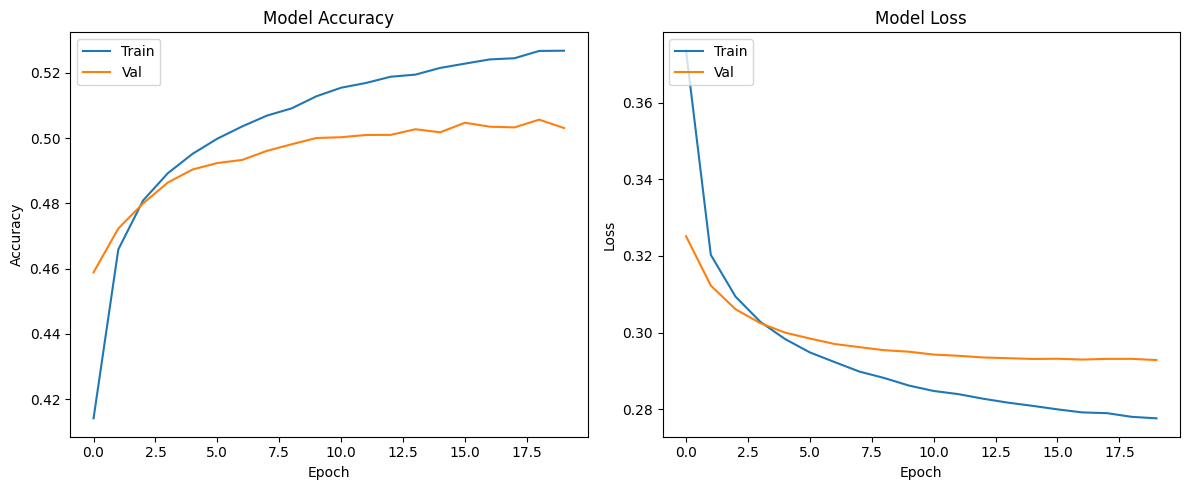

In [24]:
plt.figure(figsize=(12, 5))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['multilabel_accuracy'])
plt.plot(history.history['val_multilabel_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

Start the fine tuning using a very low leaning rate.

In [33]:
# Fine tuning
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 40)                81960     
                                                             

In [34]:
# Compile with a really low learning rate
learning_rate = 1e-5
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss="binary_crossentropy",
    metrics=[multi_label_accuracy],
)

In [32]:
# Early stopping
patience = 10
es = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [35]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[es])

Epoch 1/10
79/79 [==============================] - 5345s 68s/step - loss: 0.2634 - multilabel_accuracy: 0.5412 - val_loss: 0.2698 - val_multilabel_accuracy: 0.5397
Epoch 2/10
79/79 [==============================] - 4839s 62s/step - loss: 0.2491 - multilabel_accuracy: 0.5725 - val_loss: 0.2623 - val_multilabel_accuracy: 0.5526
Epoch 3/10
79/79 [==============================] - 3483s 44s/step - loss: 0.2410 - multilabel_accuracy: 0.5860 - val_loss: 0.2579 - val_multilabel_accuracy: 0.5598
Epoch 4/10
79/79 [==============================] - 2530s 32s/step - loss: 0.2348 - multilabel_accuracy: 0.5944 - val_loss: 0.2550 - val_multilabel_accuracy: 0.5640
Epoch 5/10
79/79 [==============================] - 2283s 29s/step - loss: 0.2293 - multilabel_accuracy: 0.6043 - val_loss: 0.2528 - val_multilabel_accuracy: 0.5684
Epoch 6/10
79/79 [==============================] - 2224s 28s/step - loss: 0.2247 - multilabel_accuracy: 0.6117 - val_loss: 0.2511 - val_multilabel_accuracy: 0.5719
Epoch 7/10

Validation metrics and plots using a threshold of 0.5 for each of the labels.

In [36]:
# Evaluate the model
probabilities = model.predict(test_dataset)
predictions = []
for i in range(len(probabilities)):
    predictions.append((probabilities[i] >= 0.5).astype(int))

20/20 [==============================] - 72s 3s/step


In [37]:
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())  # Assuming labels are in TensorFlow format
    predicted_labels.extend((preds >= 0.5).astype(int))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

5/5 [==============================] - 2s 441ms/step


In [38]:
def hamming_score(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

In [39]:
hamming_score(true_labels, predicted_labels)

0.5782790843418681

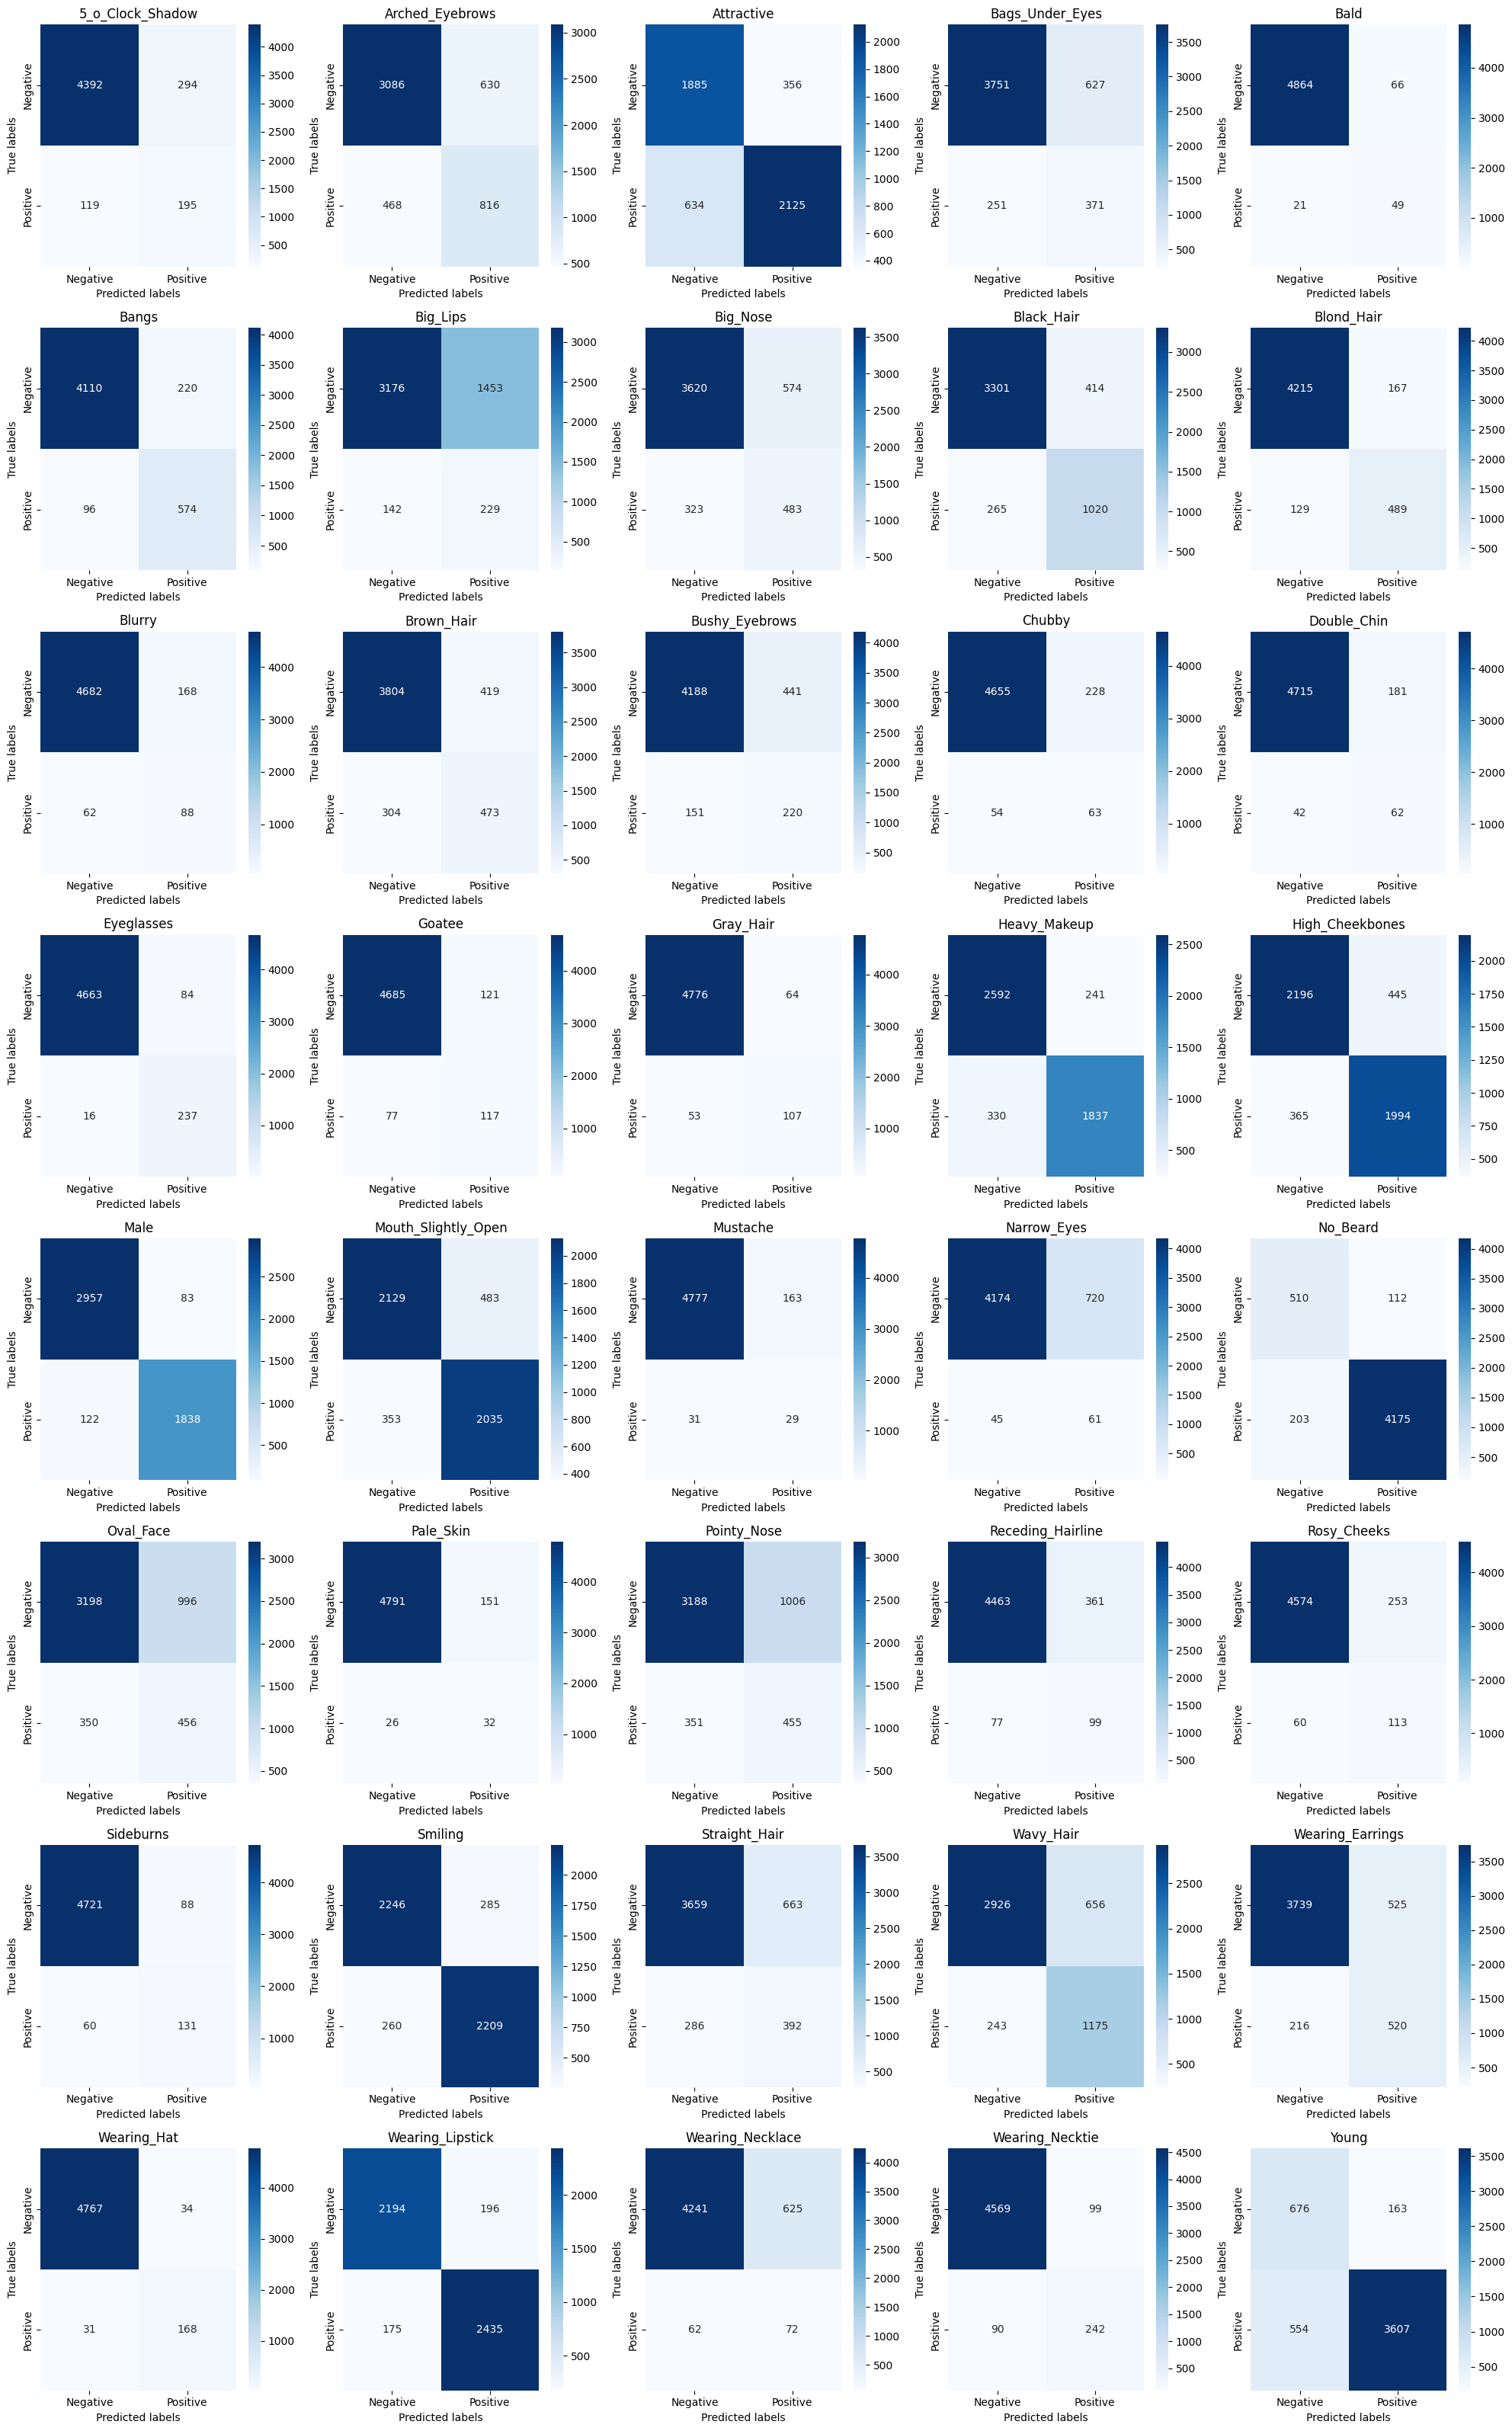

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import multilabel_confusion_matrix

df = pd.read_csv(df_path)
feature_columns = df.columns.tolist()
feature_columns.remove('image_id')

def draw_confusion_plots(true_labels, predicted_labels, feature_columns = feature_columns):
    conf_matrices = multilabel_confusion_matrix(predicted_labels, true_labels)
    fig, axes = plt.subplots(8, 5, figsize=(20, 32))  # Adjusted to 8x5 grid with appropriate figsize

    for i, cm in enumerate(conf_matrices):
        # Locate the position in the grid
        row = i // 5
        col = i % 5
        ax = axes[row, col]  # Access the subplot position
        
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(feature_columns[i])
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.xaxis.set_ticklabels(['Negative', 'Positive'])
        ax.yaxis.set_ticklabels(['Negative', 'Positive'])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

draw_confusion_plots(true_labels, predicted_labels)

In [43]:
from sklearn.metrics import precision_score, hamming_loss, recall_score, f1_score

print('Hamming loss: {0}'.format(hamming_loss(true_labels, predicted_labels))) 

print('Recall: {0}'.format(precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 

print('Precision: {0}'.format(recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')))

print('F1 Measure: {0}'.format(f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 


Hamming loss: 0.11176
Recall: 0.804748935704818
Precision: 0.6722892153245792
F1 Measure: 0.7165562268105674


Looking for better threshold. To find the best threshold for each of the 40 labels in a highly imbalanced multilabel classification setting, we make use of a technique based on optimizing the F1 score for each label independently. The F1 score is a balanced measure that considers both precision and recall, making it particularly useful in the context of imbalanced datasets.

In [81]:
# compute predictions for validation data
y_pred_probs = model.predict(validation_dataset)

20/20 [==============================] - 74s 3s/step


In [82]:
y_pred_probs.shape

(5000, 40)

In [95]:
from sklearn.metrics import f1_score
def calculate_f1_for_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return f1_score(y_true, y_pred)

In [106]:
def get_true_labels(data):
    y_true = []
    for _, labels in data:
        y_true.append(labels)

    # Concatenate all the tensors in the list along the first dimension
    # This results in a single tensor of shape (num_samples, num_labels)
    y_true = tf.concat(y_true, axis=0)

    # To convert this tensor to a numpy array if needed:
    y_true = y_true.numpy()
    return y_true

y_true = get_true_labels(validation_dataset)

In [93]:
def find_best_thresholds(y_true, y_pred_probs):
    best_thresholds = []
    for i in range(y_pred_probs.shape[1]):  # Assuming y_pred_probs is shape (num_samples, num_labels)
        label_probs = y_pred_probs[:, i]
        label_true = y_true[:, i]
        
        thresholds = np.linspace(0, 1, 100)  # 100 points between 0 and 1
        f1_scores = [calculate_f1_for_threshold(label_true, label_probs, t) for t in thresholds]
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)
        
        print(f"Label {i} - Best Threshold: {best_threshold} with F1 Score: {max(f1_scores)}")
    
    return best_thresholds

In [96]:
best_thresholds = find_best_thresholds(y_true, y_pred_probs)

Label 0 - Best Threshold: 0.31313131313131315 with F1 Score: 0.6026785714285714
Label 1 - Best Threshold: 0.29292929292929293 with F1 Score: 0.6476683937823835
Label 2 - Best Threshold: 0.37373737373737376 with F1 Score: 0.8052724077328646
Label 3 - Best Threshold: 0.23232323232323235 with F1 Score: 0.5398326664241543
Label 4 - Best Threshold: 0.30303030303030304 with F1 Score: 0.6213592233009707
Label 5 - Best Threshold: 0.25252525252525254 with F1 Score: 0.7935921133703019
Label 6 - Best Threshold: 0.23232323232323235 with F1 Score: 0.37680140597539546
Label 7 - Best Threshold: 0.22222222222222224 with F1 Score: 0.6274509803921569
Label 8 - Best Threshold: 0.29292929292929293 with F1 Score: 0.7361912613355317
Label 9 - Best Threshold: 0.38383838383838387 with F1 Score: 0.7924773022049286
Label 10 - Best Threshold: 0.25252525252525254 with F1 Score: 0.5426356589147286
Label 11 - Best Threshold: 0.24242424242424243 with F1 Score: 0.6205450733752621
Label 12 - Best Threshold: 0.34343434

In [113]:
print(best_thresholds)

[0.31313131313131315, 0.29292929292929293, 0.37373737373737376, 0.23232323232323235, 0.30303030303030304, 0.25252525252525254, 0.23232323232323235, 0.22222222222222224, 0.29292929292929293, 0.38383838383838387, 0.25252525252525254, 0.24242424242424243, 0.3434343434343435, 0.18181818181818182, 0.16161616161616163, 0.2828282828282829, 0.3535353535353536, 0.27272727272727276, 0.42424242424242425, 0.4141414141414142, 0.4040404040404041, 0.4747474747474748, 0.22222222222222224, 0.24242424242424243, 0.5050505050505051, 0.29292929292929293, 0.22222222222222224, 0.29292929292929293, 0.16161616161616163, 0.21212121212121213, 0.4545454545454546, 0.4646464646464647, 0.27272727272727276, 0.43434343434343436, 0.29292929292929293, 0.5656565656565657, 0.5050505050505051, 0.21212121212121213, 0.2828282828282829, 0.4141414141414142]


In [102]:
# Test predictions
test_preds  = model.predict(test_dataset)

20/20 [==============================] - 82s 4s/step


In [104]:
def apply_thresholds(y_probs, thresholds):
    return (y_probs >= thresholds).astype(int)

pred_labels = apply_thresholds(test_preds, best_thresholds)

In [107]:
# Get true labels
true_test_label = get_true_labels(test_dataset)

In [108]:
# Hamming score
hamming_score(true_test_label, pred_labels)

0.579419770858654

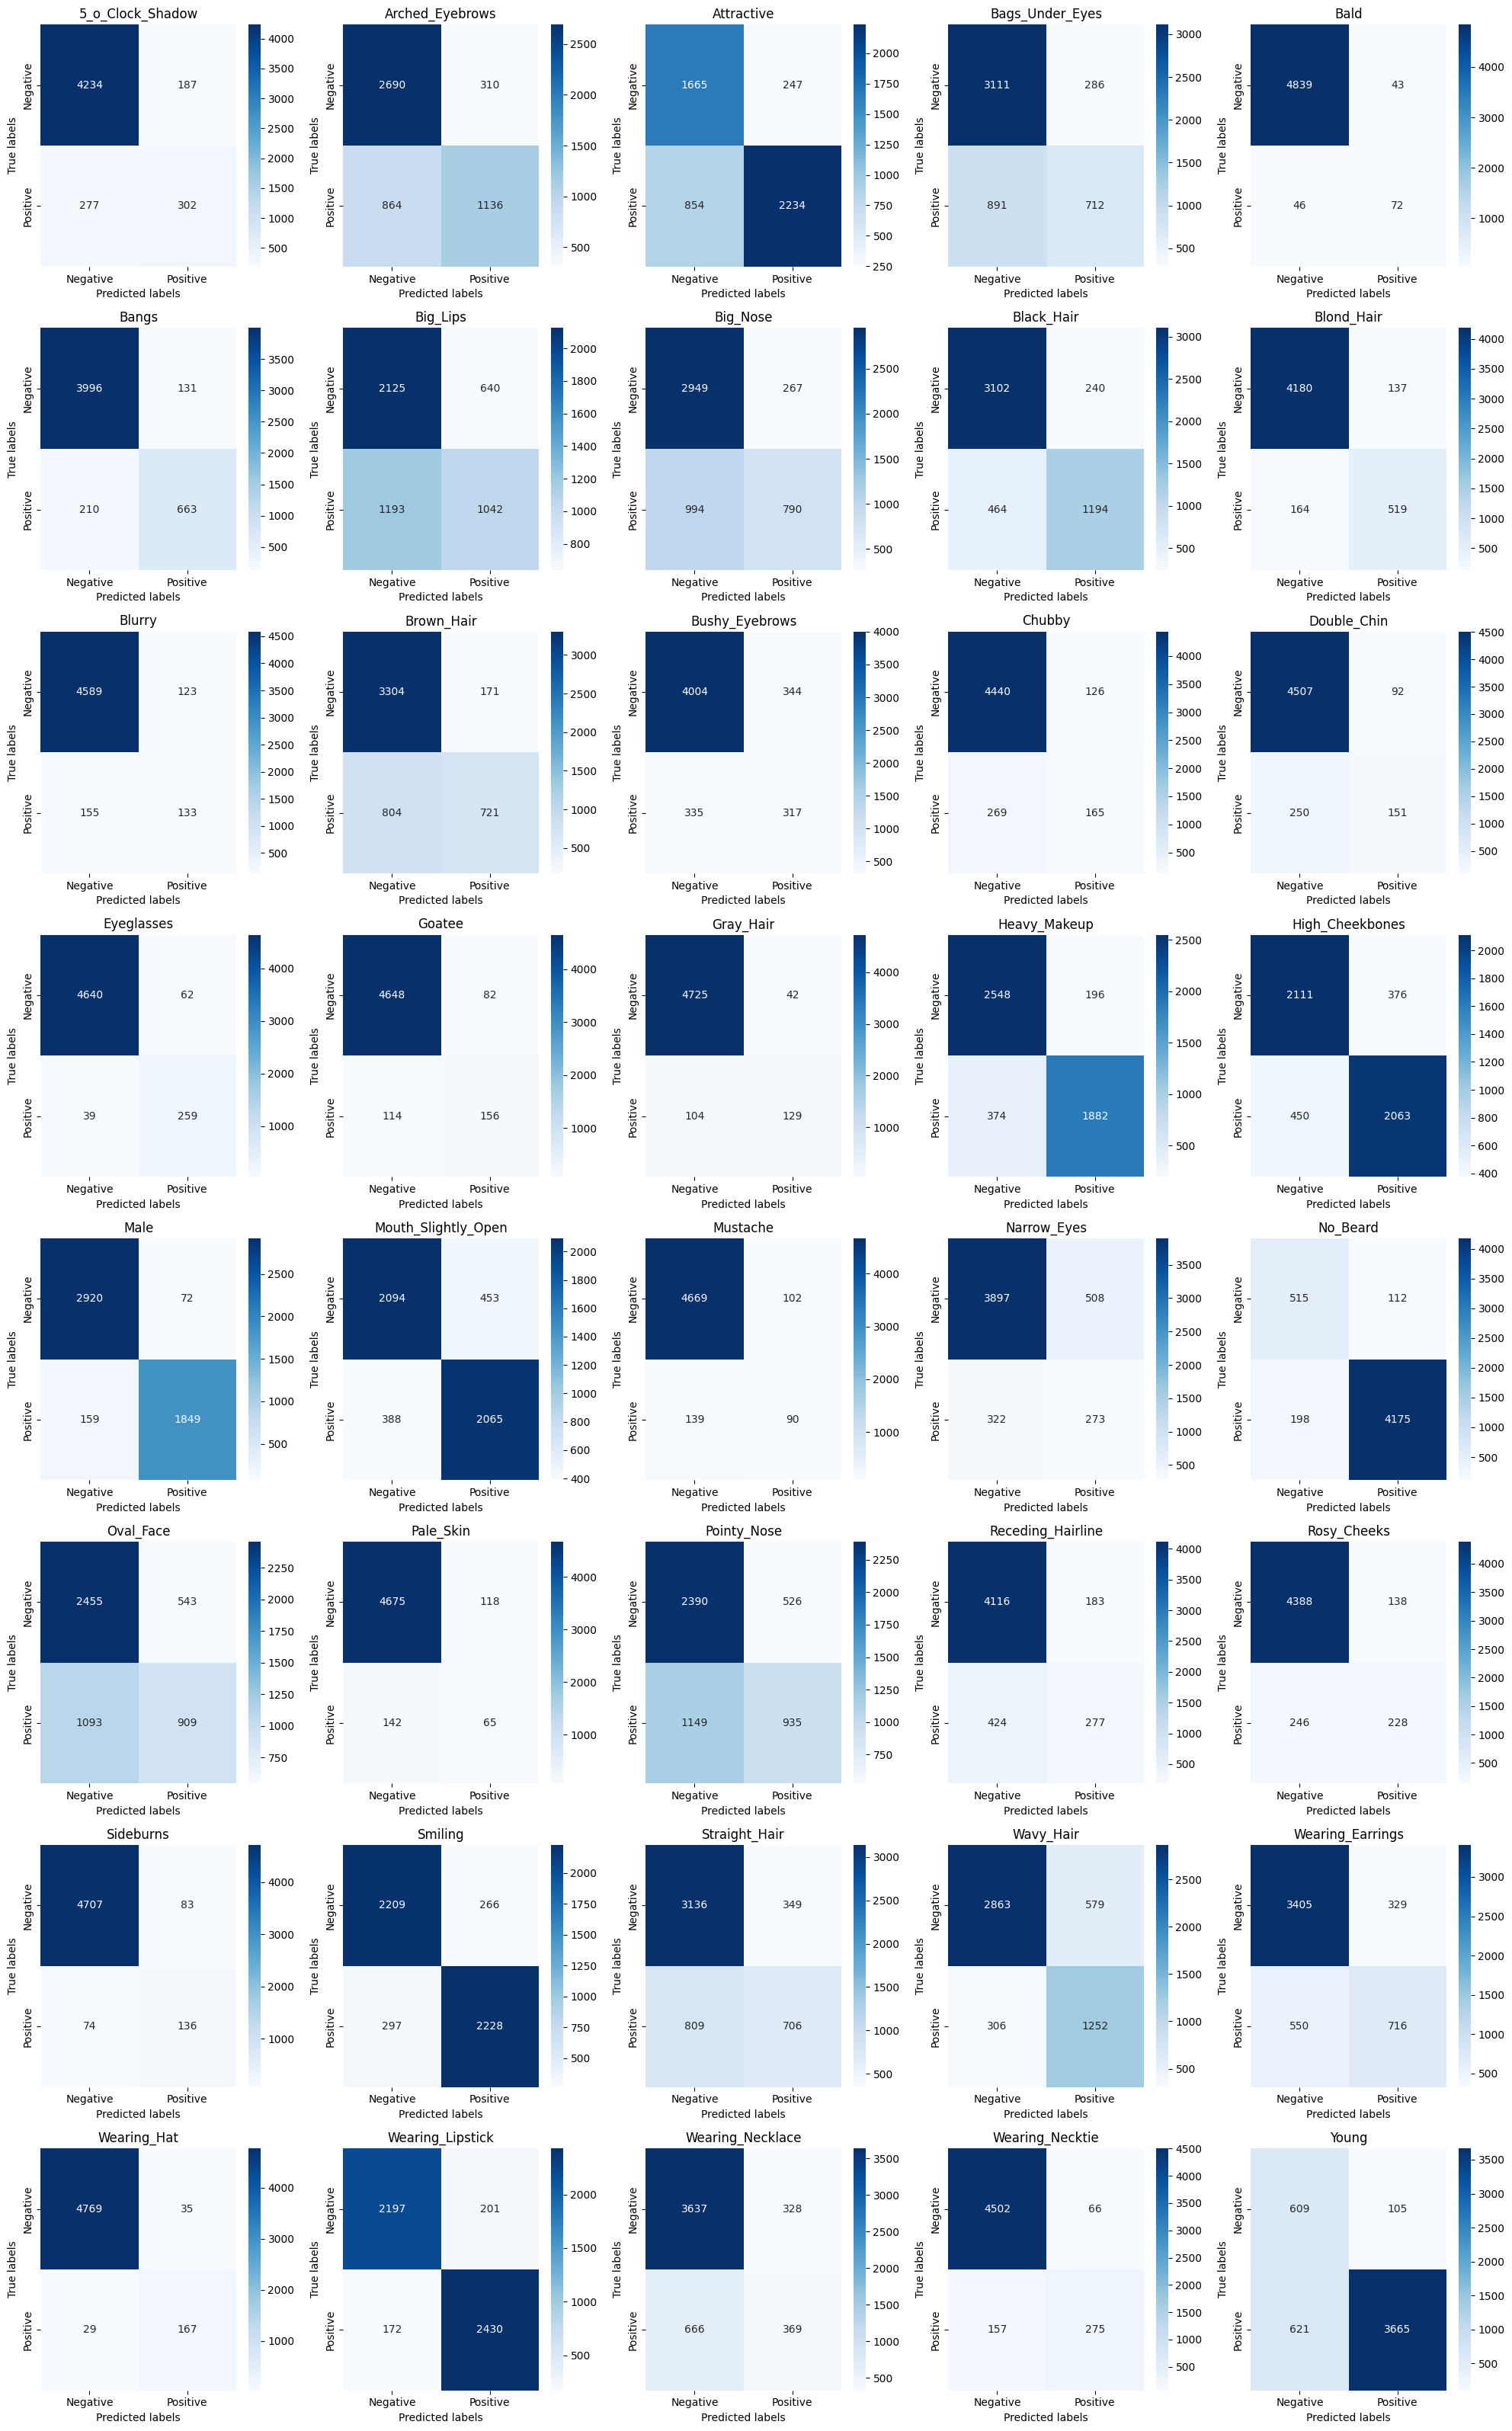

In [110]:
# Draw the confusion matrices
draw_confusion_plots(true_test_label, pred_labels)

In [111]:
print('Hamming loss: {0}'.format(hamming_loss(true_labels, predicted_labels))) 

print('Recall: {0}'.format(precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 

print('Precision: {0}'.format(recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')))

print('F1 Measure: {0}'.format(f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 

Hamming loss: 0.11176
Recall: 0.804748935704818
Precision: 0.6722892153245792
F1 Measure: 0.7165562268105674


In [114]:
model.save("transfer_learning_model.h5")

/Users/leemabhena/Documents/williams-cs/python-practice/env/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
